In [21]:
import pandas as pd

df = pd.read_csv("./veri776_metadata.csv") 
df_train = df[df['split'] == 'train'].reset_index(drop=True)
df_val = df[df['split'] == 'validation'].reset_index(drop=True)
df_val

,label,cam_id,split,is_query,is_gallery,path
0,2,2,validation,True,True,veri776_ds\0002_c002_00030600_0.jpg
1,2,3,validation,True,True,veri776_ds\0002_c003_00084280_0.jpg
2,2,4,validation,True,True,veri776_ds\0002_c004_00084250_0.jpg
3,2,5,validation,True,True,veri776_ds\0002_c005_00084980_0.jpg
4,2,6,validation,True,True,veri776_ds\0002_c006_00083605_0.jpg
...,...,...,...,...,...,...
11574,776,7,validation,False,True,veri776_ds\0776_c007_00000595_0.jpg
11575,776,7,validation,False,True,veri776_ds\0776_c007_00000610_0.jpg
11576,776,7,validation,False,True,veri776_ds\0776_c007_00000620_0.jpg
11577,776,7,validation,False,True,veri776_ds\0776_c007_00000625_0.jpg


In [22]:
import argparse
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import numpy as np
from metrics.eval_reid import *
from data.triplet_sampler import *
from typing import OrderedDict
from processor import get_model
import torch.multiprocessing
import os
import yaml
from utils import re_ranking

with open("./10/config.yaml", "r") as stream:
        data = yaml.safe_load(stream)


teste_transform = transforms.Compose([
                transforms.Resize((data['y_length'],data['x_length']), antialias=True),
                transforms.Normalize(data['n_mean'], data['n_std']),

])                  

if data['half_precision']:
    scaler = torch.cuda.amp.GradScaler()
else:
    scaler=False


if data['dataset'] == 'Veri776':
    data_q = CustomDataSet4Veri776_withviewpont(data['query_list_file'], data['query_dir'], data['train_keypoint'], data['test_keypoint'], is_train=False, transform=teste_transform)
    data_g = CustomDataSet4Veri776_withviewpont(data['gallery_list_file'], data['teste_dir'], data['train_keypoint'], data['test_keypoint'], is_train=False, transform=teste_transform)
    data_q = DataLoader(data_q, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])
    data_g = DataLoader(data_g, batch_size=data['BATCH_SIZE'], shuffle=False, num_workers=data['num_workers_teste'])


# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

model = get_model(data, torch.device("cpu"))

# One of the saved weights last.pt best_CMC.pt best_mAP.pt
path_weights = './10/best_mAP.pt'

try:
    model.load_state_dict(torch.load(path_weights, map_location='cpu')) 
except RuntimeError:
    ### nn.Parallel adds "module." to the dict names. Although like said nn.Parallel can incur in weird results in some cases 
    tmp = torch.load(path_weights, map_location='cpu')
    tmp = OrderedDict((k.replace("module.", ""), v) for k, v in tmp.items())
    model.load_state_dict(tmp)


model = model.to(device)
model.eval()

mean = False
l2 = True

C:\Users\pnkdl\AppData\Local\Temp\ipykernel_11508\1084257787.py:28: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Missed viewpoint for  0  images!
Missed viewpoint for  0  images!
Selected device: cuda


Using cache found in C:\Users\pnkdl/.cache\torch\hub\XingangPan_IBN-Net_master
Using cache found in C:\Users\pnkdl/.cache\torch\hub\XingangPan_IBN-Net_master
C:\Users\pnkdl\AppData\Local\Temp\ipykernel_11508\1084257787.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the 

In [23]:
import torch.nn as nn


class EmbeddingModel(nn.Module):
    def __init__(self, original_model):
        super(EmbeddingModel, self).__init__()
        self.original_model = original_model
    
    def forward(self, x):
        _, embs, _, _ = self.original_model(x, 0, 0)
        # Возвращаем объединенные эмбеддинги из всех ветвей
        return torch.cat(embs, dim=1)
    

embedding_model = EmbeddingModel(model)


In [24]:
teste_transform = transforms.Compose([
    transforms.ToTensor(),
                transforms.Resize((data['y_length'],data['x_length']), antialias=True),
                transforms.Normalize(data['n_mean'], data['n_std']),

])  

In [25]:

from oml import datasets as d
from oml.inference import inference
from oml.metrics import calc_retrieval_metrics_rr
from oml.models import ViTExtractor
from oml.registry import get_transforms_for_pretrained
from oml.retrieval import RetrievalResults



first_step = d.ImageLabeledDataset(df_train, transform=teste_transform)
accumulation_steps = d.ImageQueryGalleryLabeledDataset(df_val, transform=teste_transform)



In [26]:
embeddings_first = inference(embedding_model, first_step, batch_size=192, num_workers=0)

In [27]:
embeddings_accum = inference(embedding_model, accumulation_steps, batch_size=192, num_workers=0)

In [28]:
rr = RetrievalResults.from_embeddings(embeddings_accum, accumulation_steps, n_items=5)
print(1)
# rr = AdaptiveThresholding(n_std=2).process(rr)
# print(1)
print(calc_retrieval_metrics_rr(rr, map_top_k=(10000,), cmc_top_k=(1,)))

1


MAP@10000: 100%|██████████| 1678/1678 [00:00<00:00, 13420.67it/s]

{'cmc': {1: tensor(0.9952)}, 'precision': {5: tensor(0.9844)}, 'map': {10000: tensor(0.9956)}}


In [29]:
labels_first = [x['labels'] for x in first_step]
labels_first = np.array(labels_first)

In [30]:
labels_accum = [x['labels'] for x in accumulation_steps]
labels_accum = np.array(labels_accum)

In [31]:
import numpy as np

def split_dataset_by_classes(embeddings, labels, n_splits=5):
    # 1. Получаем уникальные классы
    unique_classes = np.unique(labels)
    n_classes = len(unique_classes)

    if n_classes < n_splits:
        raise ValueError(f"Недостаточно классов: {n_classes}, требуется минимум {n_splits}")

    # 2. Перемешиваем классы
    np.random.shuffle(unique_classes)

    # 3. Делим классы на n_splits групп
    class_groups = np.array_split(unique_classes, n_splits)

    # 4. Создаем список для хранения подчастей
    splits = []

    for group in class_groups:
        mask = np.isin(labels, group)
        splits.append((embeddings[mask], labels[mask]))

    return splits

In [32]:
splitted_steps = split_dataset_by_classes(embeddings_accum, labels_accum)

In [33]:
for i, (X_part, y_part) in enumerate(splitted_steps):
    print(f"Часть {i+1}: {len(X_part)} примеров, уникальные классы: {np.unique(y_part)}")

Часть 1: 2376 примеров, уникальные классы: [ 42  66  89 101 104 106 118 122 126 130 134 144 196 197 205 247 318 326
 357 391 398 402 416 446 461 518 541 546 566 569 576 581 631 660 662 672
 685 698 711 775]
Часть 2: 2105 примеров, уникальные классы: [  2  61  65  90 102 129 132 135 154 162 179 183 218 295 298 300 319 344
 373 388 392 404 418 421 427 485 486 507 515 522 543 554 584 609 622 625
 630 642 646 668]
Часть 3: 2276 примеров, уникальные классы: [  9  14  27  35  74 110 113 142 145 174 182 231 281 288 294 299 310 315
 327 332 417 473 476 480 482 494 510 586 598 602 624 659 687 699 720 727
 729 742 773 774]
Часть 4: 2389 примеров, уникальные классы: [  5  30  86 108 150 151 166 173 177 180 188 207 241 249 273 306 322 361
 365 371 420 450 456 477 545 585 597 606 612 614 652 653 654 663 676 677
 761 770 771 776]
Часть 5: 2433 примеров, уникальные классы: [  6  38  63  96 105 117 143 172 192 216 219 237 240 262 296 337 368 369
 380 385 405 467 489 570 582 588 590 593 610 615 623 634

In [14]:
parts = []
# parts = [{"embeddings": embeddings_first, "labels": labels_first}]
for i, (X_part, y_part) in enumerate(splitted_steps):
    parts.append({"embeddings": X_part, "labels": y_part})

In [15]:
from sklearn.model_selection import train_test_split
import numpy as np

# parts = [part1, part2, ..., part6]
# part = {"embeddings": embeddings_part, "labels": labels_part}

# Разделим каждую часть на train и val
train_val_parts = []

for part in parts:
    X_train, X_val, y_train, y_val = train_test_split(
        part["embeddings"], 
        part["labels"], 
        test_size=0.9,
        stratify=part["labels"],
        random_state=42
    )
    train_val_parts.append({
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val
    })

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np

# Гиперпараметры
embedding_dim = 4096  # Размерность эмбеддингов
learning_rate = 0.01
epochs = 100

# Сохраняем валидационные данные первой части
first_val_data = {
    "X": train_val_parts[1]["X_val"],
    "y": train_val_parts[1]["y_val"]
}

# Хранилище метрик
metrics_history = []

# Глобальный маппинг классов -> индекс в модели
class_to_idx = {}
known_classes = set()

# Инициализация модели
class CustomLogisticRegression(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.linear = nn.Linear(embedding_dim, num_classes, bias=True)
        # Инициализация весов
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        return self.linear(x)

# Инициализация модели
model = None
optimizer = None
# Поэтапное обучение
for i, part in enumerate(train_val_parts):
    print(f"\nЭтап {i+1}")
    
    # Получаем уникальные классы текущей части
    current_classes = np.unique(part["y_train"])
    
    # Добавляем новые классы в глобальный маппинг
    for cls in current_classes:
        if cls not in class_to_idx:
            class_to_idx[cls] = len(class_to_idx)
    known_classes.update(current_classes)
    
    # Обновляем модель, если это не первый этап или есть новые классы
    if model is None:
        # Первый этап: инициализируем модель с текущими классами
        model = CustomLogisticRegression(len(class_to_idx))
    else:
        # Расширяем модель, если появились новые классы
        old_num_classes = model.linear.out_features
        new_num_classes = len(class_to_idx)
        
        if new_num_classes > old_num_classes:
            # new_linear = nn.Linear(embedding_dim, new_num_classes, bias=True)
            # with torch.no_grad():
            #     # Копируем старые веса
            #     new_linear.weight[:old_num_classes] = model.linear.weight
            #     new_linear.bias[:old_num_classes] = model.linear.bias
            #     # Инициализируем новые веса
            #     nn.init.xavier_normal_(new_linear.weight[old_num_classes:])
            #     nn.init.zeros_(new_linear.bias[old_num_classes:])


            new_linear = nn.Linear(embedding_dim, new_num_classes, bias=True)
            with torch.no_grad():
                # Копируем старые веса как detached тензоры
                new_linear.weight[:old_num_classes] = model.linear.weight.detach().clone()
                new_linear.bias[:old_num_classes] = model.linear.bias.detach().clone()
                # Инициализируем новые веса
                nn.init.xavier_normal_(new_linear.weight[old_num_classes:])
                nn.init.zeros_(new_linear.bias[old_num_classes:])
            
            # Замораживаем старые веса
            model.linear = new_linear
            model.linear.weight.requires_grad = True
            model.linear.bias.requires_grad = True

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Перекодируем метки в новые индексы
    y_train_mapped = torch.tensor([class_to_idx[cls] for cls in part["y_train"]], dtype=torch.long)
    y_val_mapped = torch.tensor([class_to_idx[cls] for cls in part["y_val"]], dtype=torch.long)
    
    # Обучение на текущих данных
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(part["X_train"])
        loss = criterion(outputs, y_train_mapped)
        loss.backward()

        if i > 0:  # Начиная со второго этапа
            with torch.no_grad():
                model.linear.weight.grad[:old_num_classes].zero_()
                model.linear.bias.grad[:old_num_classes].zero_()

            
        optimizer.step()
    
    # Оценка на новых данных
    model.eval()
    with torch.no_grad():
        new_preds = model(part["X_val"]).argmax(dim=1)
        new_acc = accuracy_score(y_val_mapped, new_preds)
        

        old_acc = None
        if i >= 1:
            # Оценка на старых данных (первая часть)
            old_preds = model(first_val_data["X"]).argmax(dim=1)
            old_y_mapped = torch.tensor([class_to_idx[cls] for cls in first_val_data["y"]], dtype=torch.long)
            old_acc = accuracy_score(old_y_mapped, old_preds)
        
        # --- Измерение времени инференса на одном элементе ---
        inference_time = 0.0
        if True:

            # Замеряем время
            start_time = time.perf_counter()
            for _ in range(100):
                _pr = model(part["X_val"]).argmax(dim=1)
            end_time = time.perf_counter()

            # Среднее время на один элемент
            avg_inference_time = (end_time - start_time) / 100

            inference_time = avg_inference_time

        # --- Конец измерения времени ---

    # Сохраняем метрики
    metrics_history.append({
        "new": new_acc,
        "old": old_acc,
        "inference_time": inference_time  # в секундах
    })

    print(f"Accuracy на новых классах: {new_acc}")
    print(f"Accuracy на старых классах (первый этап): {old_acc}")
    print(f"Среднее время инференса на 1 элемент: {inference_time} сек")


Этап 1
Accuracy на новых классах: 0.9593023255813954
Accuracy на старых классах (первый этап): None
Среднее время инференса на 1 элемент: 0.0049479489994701 сек

Этап 2
Accuracy на новых классах: 0.9881129271916791
Accuracy на старых классах (первый этап): 0.9881129271916791
Среднее время инференса на 1 элемент: 0.006416434000711888 сек

Этап 3
Accuracy на новых классах: 0.988905698436712
Accuracy на старых классах (первый этап): 0.0
Среднее время инференса на 1 элемент: 0.006634920000797137 сек

Этап 4
Accuracy на новых классах: 0.9782135076252724
Accuracy на старых классах (первый этап): 0.0
Среднее время инференса на 1 элемент: 0.007842653000261634 сек

Этап 5
Accuracy на новых классах: 0.9723286504895701
Accuracy на старых классах (первый этап): 0.0
Среднее время инференса на 1 элемент: 0.011852355999872088 сек


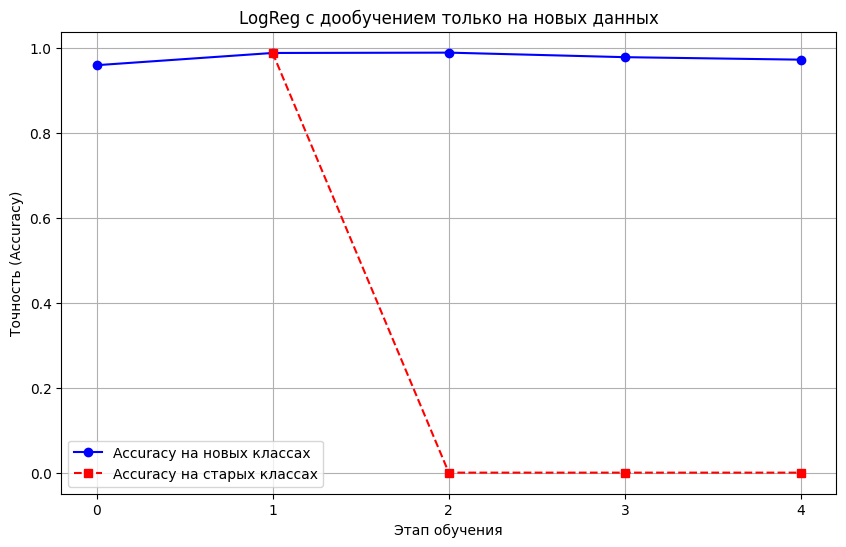

In [35]:
import matplotlib.pyplot as plt

# Список этапов
epochs = range(0, len(metrics_history))

# Списки точности для новых и старых классов
accuracy_new = [data['new'] for data in metrics_history]
accuracy_old = [data['old'] for data in metrics_history]

plt.figure(figsize=(10, 6))

# Построение графика точности для новых классов
plt.plot(epochs, accuracy_new, label='Accuracy на новых классах', marker='o', linestyle='-', color='blue')

# Построение графика точности для старых классов
plt.plot(epochs, accuracy_old, label='Accuracy на старых классах', marker='s', linestyle='--', color='red')

# Настройка осей и заголовка
plt.title('LogReg с дообучением только на новых данных')
plt.xlabel('Этап обучения')
plt.ylabel('Точность (Accuracy)')
plt.xticks(epochs)
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np

# Гиперпараметры
embedding_dim = 4096  # Размерность эмбеддингов
learning_rate = 0.01
epochs = 2000

# Сохраняем валидационные данные первой части
first_val_data = {
    "X": train_val_parts[1]["X_val"],
    "y": train_val_parts[1]["y_val"]
}

replay_buffer = {
    "X_train": [],
    "y_train": []
}

# Хранилище метрик
metrics_history = []

# Глобальный маппинг классов -> индекс в модели
class_to_idx = {}
known_classes = set()

# Инициализация модели
class CustomLogisticRegression(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.linear = nn.Linear(embedding_dim, num_classes, bias=True)
        # Инициализация весов
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)

    def forward(self, x):
        return self.linear(x)

# Инициализация модели
model = None
optimizer = None

# Поэтапное обучение
for i, part in enumerate(train_val_parts):
    print(f"\nЭтап {i+1}")
    
    # Получаем уникальные классы текущей части
    current_classes = np.unique(part["y_train"])
    
    # Добавляем новые классы в глобальный маппинг
    for cls in current_classes:
        if cls not in class_to_idx:
            class_to_idx[cls] = len(class_to_idx)
    known_classes.update(current_classes)
    
    # Обновляем модель, если это не первый этап или есть новые классы
    if model is None:
        # Первый этап: инициализируем модель с текущими классами
        model = CustomLogisticRegression(len(class_to_idx))
    else:
        # Расширяем модель, если появились новые классы
        old_num_classes = model.linear.out_features
        new_num_classes = len(class_to_idx)
        
        if new_num_classes > old_num_classes:
            new_linear = nn.Linear(embedding_dim, new_num_classes, bias=True)
            with torch.no_grad():
                # Копируем старые веса
                new_linear.weight[:old_num_classes] = model.linear.weight.detach().clone()
                new_linear.bias[:old_num_classes] = model.linear.bias.detach().clone()
                # Инициализируем новые веса
                nn.init.xavier_normal_(new_linear.weight[old_num_classes:])
                nn.init.zeros_(new_linear.bias[old_num_classes:])
            
            # Замораживаем старые веса
            model.linear = new_linear
            model.linear.weight.requires_grad = True
            model.linear.bias.requires_grad = True

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Формируем объединенные данные для обучения
    if i == 0:
        # Только текущие данные для первого этапа
        X_combined = part["X_train"]
        # Перекодируем метки текущего этапа
        y_combined = torch.tensor([class_to_idx[cls] for cls in part["y_train"]], dtype=torch.long)
    else:
        # Объединить текущие данные и данные из реплей-буфера
        X_combined = torch.cat([part["X_train"]] + replay_buffer["X_train"])
        
        # Собрать все оригинальные метки из текущего этапа и реплей-буфера
        all_y = part["y_train"].tolist()
        for y_batch in replay_buffer["y_train"]:
            all_y.extend(y_batch.tolist())
        
        # Перекодировать в текущие индексы
        y_combined = torch.tensor([class_to_idx[cls] for cls in all_y], dtype=torch.long)
    
    # Обучение на новых данных
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_combined)
        loss = criterion(outputs, y_combined)
        loss.backward()
        optimizer.step()
    
    # Оценка на новых данных
    model.eval()
    with torch.no_grad():
        new_preds = model(part["X_val"]).argmax(dim=1)
        y_val_mapped = torch.tensor([class_to_idx[cls] for cls in part["y_val"]], dtype=torch.long)
        new_acc = accuracy_score(y_val_mapped, new_preds)
        

        old_acc = None
        if i >= 1:
            # Оценка на старых данных (первая часть)
            old_preds = model(first_val_data["X"]).argmax(dim=1)
            old_y_mapped = torch.tensor([class_to_idx[cls] for cls in first_val_data["y"]], dtype=torch.long)
            old_acc = accuracy_score(old_y_mapped, old_preds)
        
        # --- Измерение времени инференса на одном элементе ---
        inference_time = 0.0
        if True:

            # Замеряем время
            start_time = time.perf_counter()
            for _ in range(10):
                _pr = model(train_val_parts[0]['X_train']).argmax(dim=1)
            end_time = time.perf_counter()

            # Среднее время на один элемент
            avg_inference_time = (end_time - start_time) / 10

            inference_time = avg_inference_time 

        # --- Конец измерения времени ---

    # Сохраняем метрики
    metrics_history.append({
        "new": new_acc,
        "old": old_acc,
        "inference_time": inference_time  # в секундах
    })
    
    print(f"Accuracy на новых классах: {new_acc}")
    print(f"Accuracy на старых классах (первый этап): {old_acc}")
    print(f"Среднее время инференса на 1 элемент: {inference_time} сек")
    
    # Добавляем текущие данные в реплей-буфер
    if isinstance(part["X_train"], np.ndarray):
        X_tensor = torch.from_numpy(part["X_train"].copy())
    else:
        X_tensor = part["X_train"].clone()

    if isinstance(part["y_train"], np.ndarray):
        y_tensor = torch.from_numpy(part["y_train"].copy())
    else:
        y_tensor = part["y_train"].clone()

    replay_buffer["X_train"].append(X_tensor)
    replay_buffer["y_train"].append(y_tensor)


Этап 1
Accuracy на новых классах: 0.9762969588550984
Accuracy на старых классах (первый этап): None
Среднее время инференса на 1 элемент: 0.0005243699997663498 сек

Этап 2
Accuracy на новых классах: 0.979692917285785
Accuracy на старых классах (первый этап): 0.979692917285785
Среднее время инференса на 1 элемент: 0.0007279000012204051 сек

Этап 3
Accuracy на новых классах: 0.9803328290468987
Accuracy на старых классах (первый этап): 0.9524517087667161
Среднее время инференса на 1 элемент: 0.0008969699963927269 сек

Этап 4
Accuracy на новых классах: 0.9754901960784313
Accuracy на старых классах (первый этап): 0.9455175829618623
Среднее время инференса на 1 элемент: 0.0012046999996528029 сек

Этап 5
Accuracy на новых классах: 0.9616858237547893
Accuracy на старых классах (первый этап): 0.912332838038633
Среднее время инференса на 1 элемент: 0.0009621899924241006 сек


In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score
import numpy as np
import time

# Проверка доступности GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используется устройство: {device}")  # [[8]]

# Гиперпараметры
embedding_dim = 4096
learning_rate = 0.01
epochs = 20

# Сохраняем валидационные данные первой части
first_val_data = {
    "X": train_val_parts[1]["X_val"].to(device),  # Перемещение на GPU
    "y": train_val_parts[1]["y_val"]
}

replay_buffer = {
    "X_train": [],
    "y_train": []
}

# Хранилище метрик
metrics_history = []

# Глобальный маппинг классов -> индекс в модели
class_to_idx = {}
known_classes = set()

# Определение новой модели с 3 скрытыми слоями
class CustomMLP(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.hidden_layers = nn.Sequential(
            nn.Linear(embedding_dim, 2048),  # Первый скрытый слой
            nn.ReLU(),
            nn.Linear(2048, 1024),          # Второй скрытый слой
            nn.ReLU(),
            nn.Linear(1024, 512),           # Третий скрытый слой
            nn.ReLU()
        )
        self.classifier = nn.Linear(512, num_classes)  # Выходной слой

        # Инициализация весов
        for layer in self.hidden_layers:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_normal_(layer.weight)
                nn.init.zeros_(layer.bias)
        nn.init.xavier_normal_(self.classifier.weight)
        nn.init.zeros_(self.classifier.bias)

    def forward(self, x):
        x = self.hidden_layers(x)
        return self.classifier(x)

# Инициализация модели
model = None
optimizer = None

# Поэтапное обучение
for i, part in enumerate(train_val_parts):
    print(f"\nЭтап {i+1}")
    
    # Получаем уникальные классы текущей части
    current_classes = np.unique(part["y_train"])
    
    # Добавляем новые классы в глобальный маппинг
    for cls in current_classes:
        if cls not in class_to_idx:
            class_to_idx[cls] = len(class_to_idx)
    known_classes.update(current_classes)
    
    # Обновляем модель
    if model is None:
        model = CustomMLP(len(class_to_idx)).to(device)  # Перемещение на GPU
    else:
        old_num_classes = model.classifier.out_features
        new_num_classes = len(class_to_idx)
        
        if new_num_classes > old_num_classes:
            new_classifier = nn.Linear(512, new_num_classes, bias=True).to(device)
            with torch.no_grad():
                new_classifier.weight[:old_num_classes] = model.classifier.weight.detach().clone()
                new_classifier.bias[:old_num_classes] = model.classifier.bias.detach().clone()
                nn.init.xavier_normal_(new_classifier.weight[old_num_classes:])
                nn.init.zeros_(new_classifier.bias[old_num_classes:])
            
            model.classifier = new_classifier

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    # Формируем объединенные данные для обучения
    if i == 0:
        X_combined = part["X_train"].to(device)
        y_combined = torch.tensor([class_to_idx[cls] for cls in part["y_train"]], dtype=torch.long).to(device)
    else:
        X_combined = torch.cat([part["X_train"].to(device)] + torch.tensor(replay_buffer["X_train"]).to(device))
        
        all_y = part["y_train"].tolist()
        for y_batch in replay_buffer["y_train"]:
            all_y.extend(y_batch.tolist())
        
        y_combined = torch.tensor([class_to_idx[cls] for cls in all_y], dtype=torch.long).to(device)
    
    # Обучение на новых данных
    criterion = nn.CrossEntropyLoss()
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = model(X_combined)
        loss = criterion(outputs, y_combined)
        loss.backward()
        optimizer.step()
    
    # Оценка на новых данных
    model.eval()
    with torch.no_grad():
        new_preds = model(part["X_val"].to(device)).argmax(dim=1).cpu().numpy()
        y_val_mapped = torch.tensor([class_to_idx[cls] for cls in part["y_val"]], dtype=torch.long).to(device)
        new_acc = accuracy_score(y_val_mapped.cpu().numpy(), new_preds)
        
        old_acc = None
        if i >= 1:
            old_preds = model(first_val_data["X"]).argmax(dim=1).cpu().numpy()
            old_y_mapped = torch.tensor([class_to_idx[cls] for cls in first_val_data["y"]], dtype=torch.long).to(device)
            old_acc = accuracy_score(old_y_mapped.cpu().numpy(), old_preds)
        
        # Измерение времени инференса
        start_time = time.perf_counter()
        for _ in range(10):
            _ = model(train_val_parts[0]['X_train'].to(device)).argmax(dim=1)
        end_time = time.perf_counter()
        avg_inference_time = (end_time - start_time) / 10

    # Сохраняем метрики
    metrics_history.append({
        "new": new_acc,
        "old": old_acc,
        "inference_time": avg_inference_time
    })
    
    print(f"Accuracy на новых классах: {new_acc}")
    print(f"Accuracy на старых классах (первый этап): {old_acc}")
    print(f"Среднее время инференса на 1 элемент: {avg_inference_time} сек")
    
     # Добавляем текущие данные в реплей-буфер
    if isinstance(part["X_train"], np.ndarray):
        X_tensor = torch.from_numpy(part["X_train"].copy())
    else:
        X_tensor = part["X_train"].clone()

    if isinstance(part["y_train"], np.ndarray):
        y_tensor = torch.from_numpy(part["y_train"].copy())
    else:
        y_tensor = part["y_train"].clone()

    replay_buffer["X_train"].append(X_tensor)
    replay_buffer["y_train"].append(y_tensor)

Используется устройство: cuda

Этап 1
Accuracy на новых классах: 0.0684257602862254
Accuracy на старых классах (первый этап): None
Среднее время инференса на 1 элемент: 0.0011810200056061148 сек

Этап 2


ValueError: only one element tensors can be converted to Python scalars

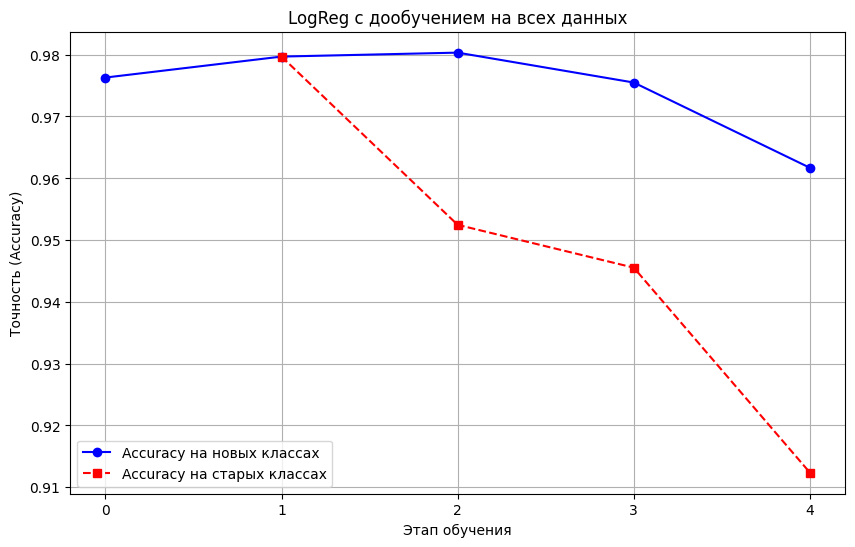

In [19]:
import matplotlib.pyplot as plt

# Список этапов
epochs = range(0, len(metrics_history))

# Списки точности для новых и старых классов
accuracy_new = [data['new'] for data in metrics_history]
accuracy_old = [data['old'] for data in metrics_history]

plt.figure(figsize=(10, 6))

# Построение графика точности для новых классов
plt.plot(epochs, accuracy_new, label='Accuracy на новых классах', marker='o', linestyle='-', color='blue')

# Построение графика точности для старых классов
plt.plot(epochs, accuracy_old, label='Accuracy на старых классах', marker='s', linestyle='--', color='red')

# Настройка осей и заголовка
plt.title('LogReg с дообучением на всех данных')
plt.xlabel('Этап обучения')
plt.ylabel('Точность (Accuracy)')
plt.xticks(epochs)
plt.legend()
plt.grid(True)

# Отображение графика
plt.show()

In [20]:
from tqdm import tqdm

In [36]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import numpy as np

# Устройство (GPU или CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Гиперпараметры
embedding_dim = 4096
learning_rate = 0.0001
batch_size = 64
epochs = 5000
num_mix = 2  # число примеров в микс

# Генератор для AdAutoMixup
class AttentionGenerator(nn.Module):
    def __init__(self, embedding_dim, num_heads=4):
        super().__init__()
        d_k = embedding_dim // num_heads
        self.num_heads = num_heads
        self.q_lin = nn.Linear(embedding_dim + 1, embedding_dim)
        self.k_lin = nn.Linear(embedding_dim + 1, embedding_dim)
        self.v_lin = nn.Linear(embedding_dim + 1, embedding_dim)
        self.out_lin = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x_set, lambdas):
        B, N, D = x_set.shape
        lam_map = lambdas.unsqueeze(-1)  # (B,N,1)
        x_emb = torch.cat([x_set, lam_map], dim=-1)  # (B,N,D+1)
        Q = self.q_lin(x_emb).view(B, N, self.num_heads, D//self.num_heads)
        K = self.k_lin(x_emb).view(B, N, self.num_heads, D//self.num_heads)
        V = self.v_lin(x_emb).view(B, N, self.num_heads, D//self.num_heads)
        scores = torch.einsum('bnhd,bmhd->bhnm', Q, K) / ((D//self.num_heads)**0.5)
        attn = F.softmax(scores, dim=-1)
        mix = torch.einsum('bhnm,bmhd->bnhd', attn, V).contiguous().view(B, N, D)
        mix = self.out_lin(mix)
        return (mix * lambdas.unsqueeze(-1)).sum(dim=1)  # (B,D)

# Классификатор
class CustomLogisticRegression(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.linear = nn.Linear(embedding_dim, num_classes)
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)
    def forward(self, x):
        return self.linear(x)

# Обёртка AdAutoMixup
class AdAutoMixup:
    def __init__(self, embedding_dim, num_classes, alpha=0.5, beta=0.3, lr_cls=1e-2, lr_gen=1e-3, ema_m=0.999):
        self.model = CustomLogisticRegression(num_classes).to(device)
        self.generator = AttentionGenerator(embedding_dim).to(device)
        self.model_ema = CustomLogisticRegression(num_classes).to(device)
        self.model_ema.load_state_dict(self.model.state_dict())
        self.ema_m = ema_m
        self.opt_cls = optim.AdamW(self.model.parameters(), lr=lr_cls)
        self.opt_gen = optim.Adam(self.generator.parameters(), lr=lr_gen)
        self.criterion = nn.CrossEntropyLoss(reduction='none')

    def update_ema(self):
        for p, p_ema in zip(self.model.parameters(), self.model_ema.parameters()):
            p_ema.data.mul_(self.ema_m).add_(p.data, alpha=1-self.ema_m)

    def soft_ce(self, logits, y_mix):
        """
        logits: (B, C), y_mix: (B, C) — распределение soft-меток
        возвращает средний soft-CE
        """
        logp = F.log_softmax(logits, dim=1)    # (B, C)
        loss = -(y_mix * logp).sum(dim=1).mean()
        return loss

    def train_batch(self, x_set, y_set, lambdas, y_mix):
        # ================= 1) Обновление классификатора =================
        self.opt_cls.zero_grad()

        x_mix = self.generator(x_set, lambdas)     # (B, D)
        logits = self.model(x_mix)                 # (B, C)
        loss_cls = self.soft_ce(logits, y_mix)     # soft-CE
        loss_cls.backward()
        self.opt_cls.step()
        self.update_ema()

        # ================= 2) Обновление генератора (adversarial) ======
        # Замораживаем классификатор
        for p in self.model.parameters():
            p.requires_grad = False

        self.opt_gen.zero_grad()
        x_mix = self.generator(x_set, lambdas)
        logits = self.model(x_mix)
        # тот же soft-CE, но градиент в обратную сторону
        loss_gen = self.soft_ce(logits, y_mix)
        # здесь градиент передаётся с минусом, но item() остаётся положительным
        loss_gen.backward(gradient=torch.tensor(-1.0, device=device))
        self.opt_gen.step()

        # Размораживаем классификатор для следующих batch’ей
        for p in self.model.parameters():
            p.requires_grad = True

        return loss_cls.item(), loss_gen.item()

# Основной цикл обучения
admix = AdAutoMixup(
    embedding_dim=embedding_dim,
    num_classes=0,
    lr_cls=learning_rate,
    lr_gen=learning_rate * 1e-4,  # генератор учим медленнее
    ema_m=0.999
)
class_to_idx = {}

for part_idx, part in enumerate(train_val_parts, start=1):
    print(f"\n=== Этап {part_idx} ===")
    # обновление класса
    for cls in np.unique(part['y_train']):
        if cls not in class_to_idx:
            class_to_idx[cls] = len(class_to_idx)
    num_classes = len(class_to_idx)
    # расширение классификатора
    if admix.model.linear.out_features != num_classes:
        admix.model = CustomLogisticRegression(num_classes).to(device)
        admix.model_ema = CustomLogisticRegression(num_classes).to(device)
        admix.model_ema.load_state_dict(admix.model.state_dict())
        admix.opt_cls = optim.AdamW(admix.model.parameters(), lr=learning_rate)

    # данные на устройство
    if isinstance(part['X_train'], np.ndarray):
        X_train = torch.from_numpy(part['X_train']).float().to(device)
    else:
        X_train = part['X_train'].clone().detach().float().to(device)
    y_train = torch.tensor([class_to_idx[c] for c in part['y_train']], dtype=torch.long, device=device)
    if isinstance(part['X_val'], np.ndarray):
        X_val = torch.from_numpy(part['X_val']).float().to(device)
    else:
        X_val = part['X_val'].clone().detach().float().to(device)
    y_val = torch.tensor([class_to_idx[c] for c in part['y_val']], dtype=torch.long, device=device)

    for ep in tqdm(range(1, epochs + 1)):
        perm = torch.randperm(X_train.size(0), device=device)
        total_cls_loss = 0.0
        total_gen_loss = 0.0
        count = 0

        for start in range(0, X_train.size(0), batch_size):
            end = min(start + batch_size, X_train.size(0))
            base_idx = perm[start:end]
            if len(base_idx) < num_mix:
                continue  # пропускаем, если мало примеров для mix

            # выборка микс-наборов
            mix_idx = torch.randint(0, X_train.size(0), (len(base_idx), num_mix), device=device)
            x_set = X_train[mix_idx]  # (B, N, D)
            y_set = y_train[mix_idx]  # (B, N)

            # λ и микс метки
            lambdas = torch.softmax(torch.randn(len(base_idx), num_mix, device=device), dim=1)
            y_onehot = F.one_hot(y_set, num_classes=num_classes).float()  # (B,N,C)
            y_mix = (y_onehot * lambdas.unsqueeze(-1)).sum(dim=1)  # (B,C)

            # обучение
            loss_cls, loss_gen = admix.train_batch(x_set, y_set, lambdas, y_mix)
            total_cls_loss += loss_cls
            total_gen_loss += loss_gen
            count += 1
        if ep % 50 == 0:
            print(f"Epoch {ep}/{epochs} - Cls Loss: {total_cls_loss/count:.4f}, Gen Loss: {total_gen_loss/count:.4f}")
        if ep % 100 == 0:
            # валидация
            admix.model.eval()
            with torch.no_grad():
                preds = admix.model(X_val).argmax(dim=1).cpu()
                acc = accuracy_score(y_val.cpu(), preds)
            print(f"Валидация: accuracy={acc:.4f}")

    # валидация
    admix.model.eval()
    with torch.no_grad():
        preds = admix.model(X_val).argmax(dim=1).cpu()
        acc = accuracy_score(y_val.cpu(), preds)
    print(f"Валидация: accuracy={acc:.4f}")


Using device: cuda


c:\Programming\veri_metric\unicom\venv\lib\site-packages\torch\nn\init.py:511: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")



=== Этап 1 ===


  1%|          | 51/5000 [00:08<13:05,  6.30it/s]

Epoch 50/5000 - Cls Loss: 3.5068, Gen Loss: 3.5037


  2%|▏         | 101/5000 [00:16<13:05,  6.23it/s]

Epoch 100/5000 - Cls Loss: 3.3409, Gen Loss: 3.3391
Валидация: accuracy=0.0103


  3%|▎         | 151/5000 [00:24<12:24,  6.51it/s]

Epoch 150/5000 - Cls Loss: 3.2156, Gen Loss: 3.2135


  4%|▍         | 201/5000 [00:31<12:09,  6.58it/s]

Epoch 200/5000 - Cls Loss: 3.1331, Gen Loss: 3.1304
Валидация: accuracy=0.0165


  5%|▌         | 251/5000 [00:39<12:20,  6.42it/s]

Epoch 250/5000 - Cls Loss: 3.0148, Gen Loss: 3.0129


  6%|▌         | 301/5000 [00:47<12:21,  6.34it/s]

Epoch 300/5000 - Cls Loss: 2.9326, Gen Loss: 2.9302
Валидация: accuracy=0.0192


  7%|▋         | 351/5000 [00:54<12:00,  6.45it/s]

Epoch 350/5000 - Cls Loss: 2.8626, Gen Loss: 2.8609


  8%|▊         | 401/5000 [01:02<11:51,  6.47it/s]

Epoch 400/5000 - Cls Loss: 2.7258, Gen Loss: 2.7237
Валидация: accuracy=0.0192


  9%|▉         | 451/5000 [01:10<11:31,  6.57it/s]

Epoch 450/5000 - Cls Loss: 2.6749, Gen Loss: 2.6732


 10%|█         | 501/5000 [01:17<11:12,  6.69it/s]

Epoch 500/5000 - Cls Loss: 2.6535, Gen Loss: 2.6515
Валидация: accuracy=0.0192


 11%|█         | 551/5000 [01:25<11:24,  6.50it/s]

Epoch 550/5000 - Cls Loss: 2.5203, Gen Loss: 2.5176


 12%|█▏        | 601/5000 [01:33<11:31,  6.36it/s]

Epoch 600/5000 - Cls Loss: 2.4814, Gen Loss: 2.4794
Валидация: accuracy=0.0192


 13%|█▎        | 651/5000 [01:41<11:05,  6.54it/s]

Epoch 650/5000 - Cls Loss: 2.4658, Gen Loss: 2.4634


 14%|█▍        | 701/5000 [01:49<11:18,  6.34it/s]

Epoch 700/5000 - Cls Loss: 2.3994, Gen Loss: 2.3977
Валидация: accuracy=0.0192


 15%|█▌        | 751/5000 [01:57<11:23,  6.22it/s]

Epoch 750/5000 - Cls Loss: 2.3018, Gen Loss: 2.3002


 16%|█▌        | 801/5000 [02:04<10:59,  6.37it/s]

Epoch 800/5000 - Cls Loss: 2.2671, Gen Loss: 2.2656
Валидация: accuracy=0.0192


 17%|█▋        | 851/5000 [02:12<10:56,  6.32it/s]

Epoch 850/5000 - Cls Loss: 2.1856, Gen Loss: 2.1836


 18%|█▊        | 901/5000 [02:20<10:27,  6.53it/s]

Epoch 900/5000 - Cls Loss: 2.2198, Gen Loss: 2.2182
Валидация: accuracy=0.0192


 19%|█▉        | 951/5000 [02:28<10:14,  6.59it/s]

Epoch 950/5000 - Cls Loss: 2.1066, Gen Loss: 2.1049


 20%|██        | 1001/5000 [02:35<10:09,  6.56it/s]

Epoch 1000/5000 - Cls Loss: 2.0795, Gen Loss: 2.0778
Валидация: accuracy=0.0192


 21%|██        | 1051/5000 [02:43<10:11,  6.45it/s]

Epoch 1050/5000 - Cls Loss: 2.0500, Gen Loss: 2.0481


 22%|██▏       | 1101/5000 [02:51<09:57,  6.53it/s]

Epoch 1100/5000 - Cls Loss: 2.0218, Gen Loss: 2.0207
Валидация: accuracy=0.0192


 23%|██▎       | 1151/5000 [02:59<10:02,  6.39it/s]

Epoch 1150/5000 - Cls Loss: 1.9724, Gen Loss: 1.9706


 24%|██▍       | 1201/5000 [03:07<09:46,  6.48it/s]

Epoch 1200/5000 - Cls Loss: 1.9765, Gen Loss: 1.9750
Валидация: accuracy=0.0192


 25%|██▌       | 1251/5000 [03:14<09:47,  6.38it/s]

Epoch 1250/5000 - Cls Loss: 1.9018, Gen Loss: 1.8996


 26%|██▌       | 1301/5000 [03:22<09:45,  6.32it/s]

Epoch 1300/5000 - Cls Loss: 1.9273, Gen Loss: 1.9253
Валидация: accuracy=0.0192


 27%|██▋       | 1351/5000 [03:30<09:17,  6.54it/s]

Epoch 1350/5000 - Cls Loss: 1.7897, Gen Loss: 1.7881


 28%|██▊       | 1401/5000 [03:37<09:02,  6.63it/s]

Epoch 1400/5000 - Cls Loss: 1.8204, Gen Loss: 1.8184
Валидация: accuracy=0.0192


 29%|██▉       | 1451/5000 [03:45<09:41,  6.10it/s]

Epoch 1450/5000 - Cls Loss: 1.7519, Gen Loss: 1.7502


 30%|███       | 1501/5000 [03:53<09:02,  6.45it/s]

Epoch 1500/5000 - Cls Loss: 1.7465, Gen Loss: 1.7445
Валидация: accuracy=0.0192


 31%|███       | 1551/5000 [04:01<08:45,  6.56it/s]

Epoch 1550/5000 - Cls Loss: 1.7023, Gen Loss: 1.7002


 32%|███▏      | 1601/5000 [04:08<08:36,  6.58it/s]

Epoch 1600/5000 - Cls Loss: 1.7113, Gen Loss: 1.7098
Валидация: accuracy=0.0192


 33%|███▎      | 1651/5000 [04:16<08:37,  6.47it/s]

Epoch 1650/5000 - Cls Loss: 1.7101, Gen Loss: 1.7088


 34%|███▍      | 1701/5000 [04:24<08:25,  6.53it/s]

Epoch 1700/5000 - Cls Loss: 1.6552, Gen Loss: 1.6540
Валидация: accuracy=0.0192


 35%|███▌      | 1751/5000 [04:31<08:12,  6.60it/s]

Epoch 1750/5000 - Cls Loss: 1.6583, Gen Loss: 1.6565


 36%|███▌      | 1801/5000 [04:39<08:07,  6.56it/s]

Epoch 1800/5000 - Cls Loss: 1.5329, Gen Loss: 1.5318
Валидация: accuracy=0.0192


 37%|███▋      | 1851/5000 [04:47<08:08,  6.44it/s]

Epoch 1850/5000 - Cls Loss: 1.5676, Gen Loss: 1.5661


 38%|███▊      | 1901/5000 [04:54<08:01,  6.44it/s]

Epoch 1900/5000 - Cls Loss: 1.5766, Gen Loss: 1.5749
Валидация: accuracy=0.0192


 39%|███▉      | 1951/5000 [05:02<08:04,  6.29it/s]

Epoch 1950/5000 - Cls Loss: 1.4998, Gen Loss: 1.4988


 40%|████      | 2001/5000 [05:10<07:38,  6.53it/s]

Epoch 2000/5000 - Cls Loss: 1.4876, Gen Loss: 1.4863
Валидация: accuracy=0.0192


 41%|████      | 2051/5000 [05:18<07:33,  6.50it/s]

Epoch 2050/5000 - Cls Loss: 1.4977, Gen Loss: 1.4964


 42%|████▏     | 2101/5000 [05:25<07:31,  6.42it/s]

Epoch 2100/5000 - Cls Loss: 1.4672, Gen Loss: 1.4654
Валидация: accuracy=0.0192


 43%|████▎     | 2151/5000 [05:33<07:29,  6.33it/s]

Epoch 2150/5000 - Cls Loss: 1.4258, Gen Loss: 1.4245


 44%|████▍     | 2201/5000 [05:41<07:10,  6.50it/s]

Epoch 2200/5000 - Cls Loss: 1.4266, Gen Loss: 1.4250
Валидация: accuracy=0.0192


 45%|████▌     | 2251/5000 [05:49<07:02,  6.50it/s]

Epoch 2250/5000 - Cls Loss: 1.4863, Gen Loss: 1.4847


 46%|████▌     | 2301/5000 [05:57<07:02,  6.39it/s]

Epoch 2300/5000 - Cls Loss: 1.4357, Gen Loss: 1.4343
Валидация: accuracy=0.0192


 47%|████▋     | 2351/5000 [06:04<06:46,  6.52it/s]

Epoch 2350/5000 - Cls Loss: 1.4543, Gen Loss: 1.4531


 48%|████▊     | 2401/5000 [06:12<06:43,  6.44it/s]

Epoch 2400/5000 - Cls Loss: 1.3889, Gen Loss: 1.3872
Валидация: accuracy=0.0192


 49%|████▉     | 2451/5000 [06:19<06:31,  6.51it/s]

Epoch 2450/5000 - Cls Loss: 1.4298, Gen Loss: 1.4282


 50%|█████     | 2501/5000 [06:27<06:13,  6.69it/s]

Epoch 2500/5000 - Cls Loss: 1.3725, Gen Loss: 1.3710
Валидация: accuracy=0.0192


 51%|█████     | 2551/5000 [06:35<06:34,  6.21it/s]

Epoch 2550/5000 - Cls Loss: 1.3640, Gen Loss: 1.3628


 52%|█████▏    | 2601/5000 [06:42<06:02,  6.63it/s]

Epoch 2600/5000 - Cls Loss: 1.3903, Gen Loss: 1.3889
Валидация: accuracy=0.0192


 53%|█████▎    | 2651/5000 [06:50<06:14,  6.27it/s]

Epoch 2650/5000 - Cls Loss: 1.3370, Gen Loss: 1.3354


 54%|█████▍    | 2701/5000 [06:58<05:49,  6.58it/s]

Epoch 2700/5000 - Cls Loss: 1.2987, Gen Loss: 1.2974
Валидация: accuracy=0.0192


 55%|█████▌    | 2751/5000 [07:05<05:27,  6.87it/s]

Epoch 2750/5000 - Cls Loss: 1.3226, Gen Loss: 1.3212


 56%|█████▌    | 2801/5000 [07:12<05:22,  6.82it/s]

Epoch 2800/5000 - Cls Loss: 1.2869, Gen Loss: 1.2859
Валидация: accuracy=0.0192


 57%|█████▋    | 2851/5000 [07:20<05:24,  6.63it/s]

Epoch 2850/5000 - Cls Loss: 1.2801, Gen Loss: 1.2785


 58%|█████▊    | 2901/5000 [07:27<05:08,  6.81it/s]

Epoch 2900/5000 - Cls Loss: 1.3100, Gen Loss: 1.3087
Валидация: accuracy=0.0192


 59%|█████▉    | 2951/5000 [07:35<04:57,  6.90it/s]

Epoch 2950/5000 - Cls Loss: 1.2667, Gen Loss: 1.2655


 60%|██████    | 3001/5000 [07:42<04:51,  6.86it/s]

Epoch 3000/5000 - Cls Loss: 1.2982, Gen Loss: 1.2969
Валидация: accuracy=0.0192


 61%|██████    | 3051/5000 [07:50<04:53,  6.63it/s]

Epoch 3050/5000 - Cls Loss: 1.2663, Gen Loss: 1.2654


 62%|██████▏   | 3101/5000 [07:57<04:38,  6.81it/s]

Epoch 3100/5000 - Cls Loss: 1.2605, Gen Loss: 1.2596
Валидация: accuracy=0.0192


 63%|██████▎   | 3151/5000 [08:05<04:37,  6.67it/s]

Epoch 3150/5000 - Cls Loss: 1.2022, Gen Loss: 1.2009


 64%|██████▍   | 3201/5000 [08:12<04:29,  6.69it/s]

Epoch 3200/5000 - Cls Loss: 1.2399, Gen Loss: 1.2389
Валидация: accuracy=0.0192


 65%|██████▌   | 3251/5000 [08:20<04:15,  6.85it/s]

Epoch 3250/5000 - Cls Loss: 1.2152, Gen Loss: 1.2138


 66%|██████▌   | 3301/5000 [08:27<04:08,  6.85it/s]

Epoch 3300/5000 - Cls Loss: 1.2190, Gen Loss: 1.2179
Валидация: accuracy=0.0192


 67%|██████▋   | 3351/5000 [08:34<04:13,  6.51it/s]

Epoch 3350/5000 - Cls Loss: 1.2432, Gen Loss: 1.2419


 68%|██████▊   | 3401/5000 [08:42<04:11,  6.36it/s]

Epoch 3400/5000 - Cls Loss: 1.1936, Gen Loss: 1.1925
Валидация: accuracy=0.0192


 69%|██████▉   | 3451/5000 [08:49<03:50,  6.71it/s]

Epoch 3450/5000 - Cls Loss: 1.2248, Gen Loss: 1.2238


 70%|███████   | 3501/5000 [08:57<03:46,  6.62it/s]

Epoch 3500/5000 - Cls Loss: 1.2370, Gen Loss: 1.2358
Валидация: accuracy=0.0192


 71%|███████   | 3551/5000 [09:04<03:33,  6.78it/s]

Epoch 3550/5000 - Cls Loss: 1.2022, Gen Loss: 1.2009


 72%|███████▏  | 3601/5000 [09:12<03:26,  6.78it/s]

Epoch 3600/5000 - Cls Loss: 1.1858, Gen Loss: 1.1848
Валидация: accuracy=0.0192


 73%|███████▎  | 3651/5000 [09:19<03:19,  6.78it/s]

Epoch 3650/5000 - Cls Loss: 1.1793, Gen Loss: 1.1785


 74%|███████▍  | 3701/5000 [09:27<03:10,  6.82it/s]

Epoch 3700/5000 - Cls Loss: 1.1611, Gen Loss: 1.1598
Валидация: accuracy=0.0192


 75%|███████▌  | 3751/5000 [09:34<03:10,  6.57it/s]

Epoch 3750/5000 - Cls Loss: 1.1442, Gen Loss: 1.1429


 76%|███████▌  | 3801/5000 [09:41<02:53,  6.91it/s]

Epoch 3800/5000 - Cls Loss: 1.1740, Gen Loss: 1.1733
Валидация: accuracy=0.0192


 77%|███████▋  | 3851/5000 [09:49<02:53,  6.62it/s]

Epoch 3850/5000 - Cls Loss: 1.1674, Gen Loss: 1.1658


 78%|███████▊  | 3901/5000 [09:56<02:45,  6.65it/s]

Epoch 3900/5000 - Cls Loss: 1.1818, Gen Loss: 1.1804
Валидация: accuracy=0.0192


 79%|███████▉  | 3951/5000 [10:04<02:32,  6.88it/s]

Epoch 3950/5000 - Cls Loss: 1.1530, Gen Loss: 1.1515


 80%|████████  | 4001/5000 [10:11<02:31,  6.59it/s]

Epoch 4000/5000 - Cls Loss: 1.1544, Gen Loss: 1.1534
Валидация: accuracy=0.0192


 81%|████████  | 4051/5000 [10:19<02:19,  6.80it/s]

Epoch 4050/5000 - Cls Loss: 1.1566, Gen Loss: 1.1554


 82%|████████▏ | 4101/5000 [10:27<02:14,  6.66it/s]

Epoch 4100/5000 - Cls Loss: 1.1605, Gen Loss: 1.1596
Валидация: accuracy=0.0192


 83%|████████▎ | 4151/5000 [10:34<02:05,  6.74it/s]

Epoch 4150/5000 - Cls Loss: 1.1141, Gen Loss: 1.1130


 84%|████████▍ | 4201/5000 [10:41<01:55,  6.92it/s]

Epoch 4200/5000 - Cls Loss: 1.1012, Gen Loss: 1.0999
Валидация: accuracy=0.0192


 85%|████████▌ | 4251/5000 [10:48<01:48,  6.90it/s]

Epoch 4250/5000 - Cls Loss: 1.0901, Gen Loss: 1.0888


 86%|████████▌ | 4301/5000 [10:55<01:40,  6.96it/s]

Epoch 4300/5000 - Cls Loss: 1.1042, Gen Loss: 1.1029
Валидация: accuracy=0.0192


 87%|████████▋ | 4351/5000 [11:03<01:40,  6.46it/s]

Epoch 4350/5000 - Cls Loss: 1.0719, Gen Loss: 1.0706


 88%|████████▊ | 4401/5000 [11:11<01:32,  6.46it/s]

Epoch 4400/5000 - Cls Loss: 1.1172, Gen Loss: 1.1162
Валидация: accuracy=0.0192


 89%|████████▉ | 4451/5000 [11:18<01:24,  6.52it/s]

Epoch 4450/5000 - Cls Loss: 1.0456, Gen Loss: 1.0445


 90%|█████████ | 4501/5000 [11:26<01:17,  6.43it/s]

Epoch 4500/5000 - Cls Loss: 1.0949, Gen Loss: 1.0934
Валидация: accuracy=0.0192


 91%|█████████ | 4551/5000 [11:34<01:08,  6.56it/s]

Epoch 4550/5000 - Cls Loss: 1.0714, Gen Loss: 1.0703


 92%|█████████▏| 4601/5000 [11:41<01:00,  6.62it/s]

Epoch 4600/5000 - Cls Loss: 1.0740, Gen Loss: 1.0731
Валидация: accuracy=0.0192


 93%|█████████▎| 4651/5000 [11:49<00:53,  6.57it/s]

Epoch 4650/5000 - Cls Loss: 1.0709, Gen Loss: 1.0701


 94%|█████████▍| 4701/5000 [11:57<00:46,  6.45it/s]

Epoch 4700/5000 - Cls Loss: 1.1044, Gen Loss: 1.1026
Валидация: accuracy=0.0192


 95%|█████████▌| 4751/5000 [12:04<00:38,  6.53it/s]

Epoch 4750/5000 - Cls Loss: 1.0622, Gen Loss: 1.0612


 96%|█████████▌| 4801/5000 [12:12<00:30,  6.43it/s]

Epoch 4800/5000 - Cls Loss: 1.0879, Gen Loss: 1.0865
Валидация: accuracy=0.0192


 97%|█████████▋| 4851/5000 [12:20<00:23,  6.31it/s]

Epoch 4850/5000 - Cls Loss: 1.0494, Gen Loss: 1.0487


 98%|█████████▊| 4901/5000 [12:28<00:15,  6.31it/s]

Epoch 4900/5000 - Cls Loss: 1.0428, Gen Loss: 1.0411
Валидация: accuracy=0.0192


 99%|█████████▉| 4951/5000 [12:36<00:07,  6.31it/s]

Epoch 4950/5000 - Cls Loss: 0.9974, Gen Loss: 0.9962


100%|██████████| 5000/5000 [12:43<00:00,  6.55it/s]


Epoch 5000/5000 - Cls Loss: 1.0655, Gen Loss: 1.0645
Валидация: accuracy=0.0192
Валидация: accuracy=0.0192

=== Этап 2 ===


  1%|          | 51/5000 [00:07<12:49,  6.43it/s]

Epoch 50/5000 - Cls Loss: 3.4962, Gen Loss: 3.4939


  2%|▏         | 101/5000 [00:15<12:19,  6.62it/s]

Epoch 100/5000 - Cls Loss: 3.3495, Gen Loss: 3.3461
Валидация: accuracy=0.0198


  3%|▎         | 151/5000 [00:22<12:09,  6.65it/s]

Epoch 150/5000 - Cls Loss: 3.2323, Gen Loss: 3.2293


  4%|▍         | 201/5000 [00:30<12:01,  6.66it/s]

Epoch 200/5000 - Cls Loss: 3.1858, Gen Loss: 3.1834
Валидация: accuracy=0.0149


  5%|▌         | 251/5000 [00:37<11:51,  6.67it/s]

Epoch 250/5000 - Cls Loss: 3.0445, Gen Loss: 3.0426


  6%|▌         | 301/5000 [00:45<11:47,  6.65it/s]

Epoch 300/5000 - Cls Loss: 2.9752, Gen Loss: 2.9733
Валидация: accuracy=0.0099


  7%|▋         | 351/5000 [00:52<11:31,  6.72it/s]

Epoch 350/5000 - Cls Loss: 2.9083, Gen Loss: 2.9055


  8%|▊         | 401/5000 [01:00<11:30,  6.66it/s]

Epoch 400/5000 - Cls Loss: 2.7838, Gen Loss: 2.7816
Валидация: accuracy=0.0069


  9%|▉         | 451/5000 [01:07<11:22,  6.66it/s]

Epoch 450/5000 - Cls Loss: 2.7311, Gen Loss: 2.7277


 10%|█         | 501/5000 [01:15<11:14,  6.67it/s]

Epoch 500/5000 - Cls Loss: 2.6711, Gen Loss: 2.6687
Валидация: accuracy=0.0074


 11%|█         | 551/5000 [01:22<11:07,  6.66it/s]

Epoch 550/5000 - Cls Loss: 2.5544, Gen Loss: 2.5520


 12%|█▏        | 601/5000 [01:30<10:59,  6.67it/s]

Epoch 600/5000 - Cls Loss: 2.5195, Gen Loss: 2.5173
Валидация: accuracy=0.0030


 13%|█▎        | 651/5000 [01:37<10:50,  6.69it/s]

Epoch 650/5000 - Cls Loss: 2.4730, Gen Loss: 2.4698


 14%|█▍        | 701/5000 [01:45<10:43,  6.68it/s]

Epoch 700/5000 - Cls Loss: 2.3658, Gen Loss: 2.3632
Валидация: accuracy=0.0010


 15%|█▌        | 751/5000 [01:52<10:37,  6.67it/s]

Epoch 750/5000 - Cls Loss: 2.2544, Gen Loss: 2.2523


 16%|█▌        | 801/5000 [02:00<10:37,  6.59it/s]

Epoch 800/5000 - Cls Loss: 2.2742, Gen Loss: 2.2720
Валидация: accuracy=0.0000


 17%|█▋        | 851/5000 [02:07<10:28,  6.60it/s]

Epoch 850/5000 - Cls Loss: 2.2217, Gen Loss: 2.2200


 18%|█▊        | 901/5000 [02:15<10:36,  6.44it/s]

Epoch 900/5000 - Cls Loss: 2.1906, Gen Loss: 2.1879
Валидация: accuracy=0.0000


 19%|█▉        | 951/5000 [02:23<10:42,  6.30it/s]

Epoch 950/5000 - Cls Loss: 2.0936, Gen Loss: 2.0920


 20%|██        | 1000/5000 [02:31<10:40,  6.25it/s]

Epoch 1000/5000 - Cls Loss: 2.1359, Gen Loss: 2.1339
Валидация: accuracy=0.0000


 21%|██        | 1051/5000 [02:39<09:47,  6.72it/s]

Epoch 1050/5000 - Cls Loss: 2.0599, Gen Loss: 2.0585


 22%|██▏       | 1101/5000 [02:46<09:42,  6.69it/s]

Epoch 1100/5000 - Cls Loss: 1.9932, Gen Loss: 1.9916
Валидация: accuracy=0.0000


 23%|██▎       | 1151/5000 [02:54<10:11,  6.30it/s]

Epoch 1150/5000 - Cls Loss: 1.9706, Gen Loss: 1.9684


 24%|██▍       | 1201/5000 [03:02<09:31,  6.65it/s]

Epoch 1200/5000 - Cls Loss: 1.9249, Gen Loss: 1.9230
Валидация: accuracy=0.0000


 25%|██▌       | 1251/5000 [03:09<09:26,  6.61it/s]

Epoch 1250/5000 - Cls Loss: 1.8968, Gen Loss: 1.8948


 26%|██▌       | 1284/5000 [03:14<09:24,  6.59it/s]


KeyboardInterrupt: 

In [53]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import accuracy_score
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
embedding_dim = 4096
learning_rate = 0.001
batch_size = 64
epochs = 5000
num_mix = 3   # N samples to mix
alpha = 0.5   # weight for adversarial mix CE
beta = 0.3    # weight for EMA regularization
ema_m = 0.999

# AdAutoMixup Components
class AttentionGenerator(nn.Module):
    def __init__(self, embedding_dim, num_heads=4):
        super().__init__()
        d_k = embedding_dim // num_heads
        self.num_heads = num_heads
        self.q_lin = nn.Linear(embedding_dim + 1, embedding_dim)
        self.k_lin = nn.Linear(embedding_dim + 1, embedding_dim)
        self.v_lin = nn.Linear(embedding_dim + 1, embedding_dim)
        self.out_lin = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x_set, lambdas):
        B, N, D = x_set.shape
        lam_map = lambdas.unsqueeze(-1)  # (B,N,1)
        x_emb = torch.cat([x_set, lam_map], dim=-1)
        Q = self.q_lin(x_emb).view(B, N, self.num_heads, D//self.num_heads)
        K = self.k_lin(x_emb).view(B, N, self.num_heads, D//self.num_heads)
        V = self.v_lin(x_emb).view(B, N, self.num_heads, D//self.num_heads)
        scores = torch.einsum('bnhd,bmhd->bhnm', Q, K) / ((D//self.num_heads)**0.5)
        attn = F.softmax(scores, dim=-1)
        mix = torch.einsum('bhnm,bmhd->bnhd', attn, V).contiguous().view(B, N, D)
        mix = self.out_lin(mix)
        return (mix * lambdas.unsqueeze(-1)).sum(dim=1)

class CustomLogisticRegression(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.linear = nn.Linear(embedding_dim, num_classes)
        nn.init.xavier_normal_(self.linear.weight)
        nn.init.zeros_(self.linear.bias)
    def forward(self, x):
        return self.linear(x)

class AdAutoMixup:
    def __init__(self, embedding_dim, alpha, beta, ema_m, lr_cls, lr_gen):
        self.alpha = alpha
        self.beta = beta
        self.ema_m = ema_m
        self.generator = AttentionGenerator(embedding_dim).to(device)
        self.model = None
        self.model_ema = None
        self.opt_gen = optim.Adam(self.generator.parameters(), lr=lr_gen)
        self.opt_cls = None

    def init_models(self, num_classes):
        self.model = CustomLogisticRegression(num_classes).to(device)
        self.model_ema = CustomLogisticRegression(num_classes).to(device)
        self.model_ema.load_state_dict(self.model.state_dict())
        self.opt_cls = optim.AdamW(self.model.parameters(), lr=learning_rate)

    def update_ema(self):
        for p, p_ema in zip(self.model.parameters(), self.model_ema.parameters()):
            p_ema.data.mul_((self.ema_m)).add_(p.data, alpha=1-self.ema_m)

    def soft_ce(self, logits, targets):
        logp = F.log_softmax(logits, dim=1)
        return -(targets * logp).sum(dim=1)

    def train_batch(self, x_set, y_set, lambdas, y_mix):
        B, N, D = x_set.shape
        x_flat = x_set.view(-1, D)
        y_flat = y_set.view(-1)

        # classifier update
        self.opt_cls.zero_grad()
        x_mix = self.generator(x_set, lambdas)
        logits_mix = self.model(x_mix)
        loss_adv = self.soft_ce(logits_mix, y_mix).mean()
        # original mix CE
        x_linear = (x_flat * lambdas.view(B, N, 1).expand(-1, -1, D)).sum(1)
        logits_lin = self.model(x_linear)
        loss_lin = F.cross_entropy(logits_lin, y_mix.argmax(1))
        loss_cls = loss_adv * self.alpha + loss_lin * (1-self.alpha)
        loss_cls.backward()
        self.opt_cls.step()
        self.update_ema()   

        # generator update (adversarial)
        for p in self.model.parameters(): p.requires_grad = False
        self.opt_gen.zero_grad()
        x_mix2 = self.generator(x_set, lambdas)
        logits2 = self.model(x_mix2)
        loss2 = self.soft_ce(logits2, y_mix).mean()
        # EMA regularization
        with torch.no_grad(): ema_logits = self.model_ema(x_mix2)
        loss_ema = self.soft_ce(ema_logits, y_mix).mean()
        cos_sim = F.cosine_similarity(self.model_ema(x_mix2), self.model_ema(x_flat.view(B, N, D).mean(1))).mean()
        loss_gen = loss2 - self.beta * loss_ema + (1-self.beta) * cos_sim
        (-loss_gen).backward()
        self.opt_gen.step()
        for p in self.model.parameters(): p.requires_grad = True

        return loss_cls.item(), loss_gen.item()

# Training loop example usage
admix = AdAutoMixup(embedding_dim, alpha, beta, ema_m, lr_cls=learning_rate, lr_gen=learning_rate*1e-4)

# assume train_val_parts is list of dicts with 'X_train','y_train','X_val','y_val'
class_to_idx = {}
for part in train_val_parts:
    for c in np.unique(part['y_train']):
        if c not in class_to_idx: class_to_idx[c] = len(class_to_idx)
    num_classes = len(class_to_idx)
    if admix.model is None or admix.model.linear.out_features != num_classes:
        admix.init_models(num_classes)

    X_train = torch.tensor(part['X_train'], dtype=torch.float32, device=device)
    y_train = torch.tensor([class_to_idx[c] for c in part['y_train']], device=device)
    X_val = torch.tensor(part['X_val'], dtype=torch.float32, device=device)
    y_val = torch.tensor([class_to_idx[c] for c in part['y_val']], device=device)

    for ep in range(epochs):
        perm = torch.randperm(len(y_train), device=device)
        for i in range(0, len(perm), batch_size):
            idx = perm[i:i+batch_size]
            if len(idx) < num_mix: continue
            mix_idx = torch.randint(0, len(y_train), (len(idx), num_mix), device=device)
            x_set = X_train[mix_idx]
            y_set = y_train[mix_idx]
            lambdas = torch.softmax(torch.randn(len(idx), num_mix, device=device), dim=1)
            y_onehot = F.one_hot(y_set, num_classes).float()
            y_mix = (y_onehot * lambdas.unsqueeze(-1)).sum(1)
            admix.train_batch(x_set, y_set, lambdas, y_mix)

    # validation
    admix.model.eval()
    with torch.no_grad():
        preds = admix.model(X_val).argmax(1).cpu()
        print("Val acc:", accuracy_score(y_val.cpu(), preds))


Using device: cuda


C:\Users\pnkdl\AppData\Local\Temp\ipykernel_30716\836060114.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(part['X_train'], dtype=torch.float32, device=device)
C:\Users\pnkdl\AppData\Local\Temp\ipykernel_30716\836060114.py:131: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val = torch.tensor(part['X_val'], dtype=torch.float32, device=device)


RuntimeError: The size of tensor a (192) must match the size of tensor b (3) at non-singleton dimension 1